# Peak calling DL model

## Setup

### Create an environment

#### Paste this in your terminal while in the project directory and select the 'DL_peak_calling' kernel

```
conda create -n DL_peak_calling -c conda-forge mamba python=3.9 -y && \
conda activate DL_peak_calling && \
mamba env update --file environment.yml
```

### Import and configure libraries

In [239]:
import os
import pickle
from time import gmtime, strftime
from collections import Counter
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import torch.multiprocessing as mp
from Bio import SeqIO

import matplotlib.pyplot as plt
# Uncomment to use dark plots
# plt.style.use('dark_background')
import seaborn as sns

from tqdm.notebook import tqdm

### Set a number of workers

In [2]:
# Specify instead of 'None' if necessary
num_workers = None

if not num_workers:
    num_workers = cpu_count()

num_workers

96

## Retrieve the data

#### Retrieve dyad positions

In [29]:
%%bash


for i in 1 2 3
do
    mkdir ../dataset_${i} -p

    wget \
        https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM256105$((i+6))/suppl/GSM256105$((i+6))%5FDyads%5FH3%5FCC%5Frep%5F${i}%2Ebw \
        -O ../dataset_${i}/dyads.bw \
        --no-verbose \
        2>&1
done

2024-07-30 21:08:45 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561057/suppl/GSM2561057%5FDyads%5FH3%5FCC%5Frep%5F1%2Ebw [10064746/10064746] -> "../dataset_1/dyads.bw" [1]
2024-07-30 21:08:48 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561058/suppl/GSM2561058%5FDyads%5FH3%5FCC%5Frep%5F2%2Ebw [8556133/8556133] -> "../dataset_2/dyads.bw" [1]
2024-07-30 21:08:51 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561059/suppl/GSM2561059%5FDyads%5FH3%5FCC%5Frep%5F3%2Ebw [7220516/7220516] -> "../dataset_3/dyads.bw" [1]


#### Retrieve the [S. cerevisiae (sacCer3) reference genome](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000146045.2/)

In [30]:
%%bash


wget \
    https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz \
    -O ../reference_genome.fasta.gz \
    --no-verbose \
    2>&1

gunzip \
    ../reference_genome.fasta.gz \
    --force

2024-07-30 21:08:53 URL:https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz [3843460/3843460] -> "../reference_genome.fasta.gz" [1]


#### Retrieve MNase-Exo-Seq sequence alignment map

In [35]:
%%bash


gdown \
    'https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1' \
    -O ../exoiii_dataset/exo.bam \
    2>&1

samtools \
    view \
    ../exoiii_dataset/exo.bam > ../exoiii_dataset/exo.sam \
    2>&1

Downloading...
From (original): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1
From (redirected): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1&confirm=t&uuid=907d8412-e3a5-4597-831e-351c6c21c29f
To: /home/v_sidorov/DL_peak_calling/exoiii_dataset/exo.bam
100%|██████████| 245M/245M [00:02<00:00, 87.4MB/s] 


## Analyse the data

### Load the data

#### Load the SAM file

In [36]:
exo_tlens = pd.read_csv(
    '../exoiii_dataset/exo.sam',
    sep='\t',
    names=['tlen'],
    usecols=[8],
)

exo_tlens

,tlen
0,117
1,57
2,54
3,-54
4,-57
...,...
8920963,-143
8920964,-85
8920965,-141
8920966,-145


#### Load the dyad probability distributions dictionary

In [37]:
with open('../exoiii_dataset/exo_dyad_dists.pickle', 'rb') as file:
    exo_dyad_dists = pickle.load(file)

### Analyse the data

#### Get an MNase-Exo-seq template length distribution

In [35]:
exo_tlen_dist = exo_tlens.tlen
exo_tlen_dist = exo_tlens[exo_tlen_dist.between(0, 200)] \
                                                .groupby(exo_tlen_dist) \
                                                .count()
exo_tlen_dist = exo_tlen_dist.loc[78:]
exo_tlen_dist = exo_tlen_dist / exo_tlen_dist.sum()

exo_tlen_dist

,tlen
tlen,
78,0.000264
79,0.000276
80,0.000303
81,0.000352
82,0.000381
...,...
196,0.000019
197,0.000011
198,0.000015


#### Look at the MNase-Exo-seq template length distribution

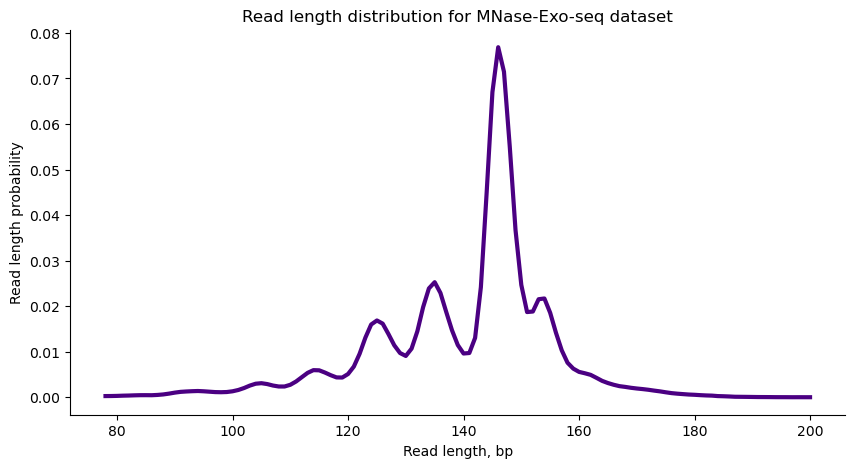

In [36]:
plt.figure(figsize=(10, 5))

ax = sns.lineplot(
    exo_tlen_dist.tlen,
    color=INDIGO,
    linewidth=3
)

plt.title('Read length distribution for MNase-Exo-seq dataset')
plt.xlabel('Read length, bp')
plt.ylabel('Read length probability')
plt.legend([], [], frameon=False)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

#### Define a function to sample a random template length from the MNase-Exo-seq template length distribution

In [37]:
def get_random_tlen():
    '''
    Samples a random template length (78–200 inclusively) from the MNase-Exo-seq template length distribution.
    
    Returns
    -------
    tlen : int
        Template length.
    '''
    tlen =  np.random.choice(
        np.arange(78, 201),
        p=exo_tlen_dist.tlen
    )
    
    return tlen

#### Look at a dyad probability distribution at an arbitrary read length

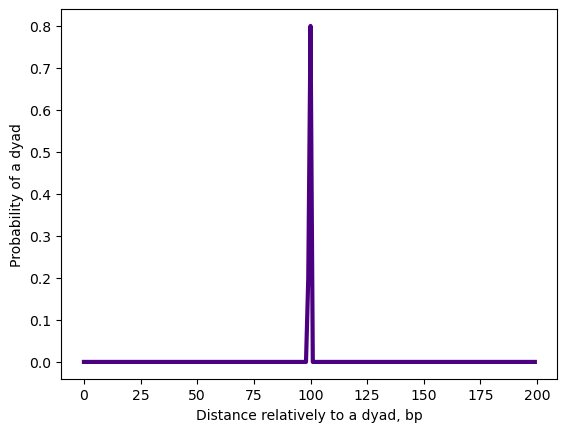

In [563]:
ax = sns.lineplot(
    exo_dyad_dists[200],
    linewidth=3,
    color=INDIGO
)

plt.xlabel('Distance relatively to a dyad, bp')
plt.ylabel('Probability of a dyad')

plt.show()

#### Define a function to sample a random dyad position from the MNase-Exo-seq dyad distribution

In [39]:
def get_random_exo_dyad_pos(length):
    '''
    Samples a random dyad position from an MNase-Exo-seq dyad distribution for a given length.
    
    Parameters
    ----------
    length : int
        Length of the template to sample from.
    
    Returns
    -------
    dyad_pos : int
        Random 1-based position of a dyad on the template of the given length.
    '''
    dyad_pos = np.random.choice(
        np.arange(1, 201),
        p=list(exo_dyad_dists[length])
    )
    
    return dyad_pos

## Prepare a dataset

### Extract dyad positions

#### Convert .bw dyad positions to .bed, removing the first non-informative line

In [39]:
%%bash

for i in 1 2 3
do
    bigWigToBedGraph ../dataset_${i}/dyads.bw ../dataset_${i}/dyads.bed

    sed 1d ../dataset_${i}/dyads.bed > ../dataset_${i}/dyads_tmp.bed

    mv ../dataset_${i}/dyads_tmp.bed ../dataset_${i}/dyads.bed
done

head -n 5 ../dataset_1/dyads.bed

chrI	32	33	2.572
chrI	33	38	0
chrI	38	39	7.715
chrI	39	66	0
chrI	66	67	12.859


#### Load the dyad positions

In [40]:
def load_dyad_positions(dataset_number):
    raw_dyad_positions = pd.read_csv(
        f'../dataset_{dataset_number}/dyads.bed',
        sep='\t',
        usecols=[0, 2, 3],
        names=['chr', 'dyad_pos', 'signal']
    )
    return raw_dyad_positions


raw_dyad_positions_1 = load_dyad_positions(1)
raw_dyad_positions_2 = load_dyad_positions(2)
raw_dyad_positions_3 = load_dyad_positions(3)

raw_dyad_positions_1

,chr,dyad_pos,signal
0,chrI,33,2.572
1,chrI,38,0.000
2,chrI,39,7.715
3,chrI,66,0.000
4,chrI,67,12.859
...,...,...,...
3383780,chrXVI,948031,0.000
3383781,chrXVI,948032,7.568
3383782,chrXVI,948034,0.000
3383783,chrXVI,948035,5.046


#### Look at signal probability distributions

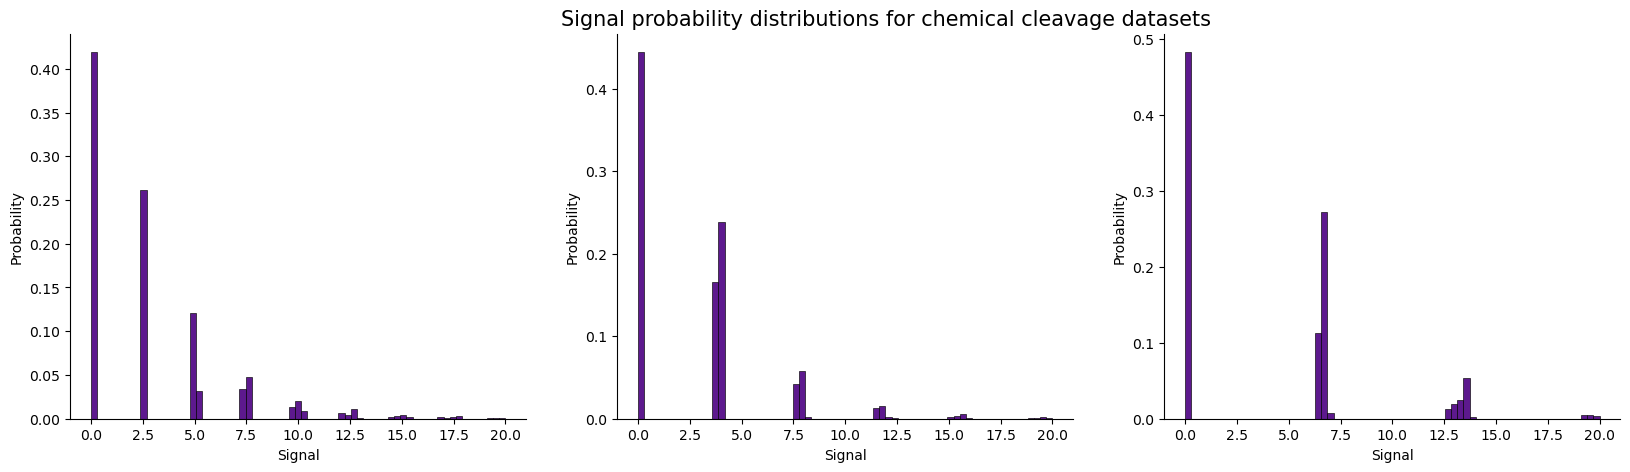

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    sns.histplot(
        eval(f'raw_dyad_positions_{i+1}.signal'),
        binwidth=0.3,
        binrange=(0, 20),
        color=INDIGO,
        alpha=0.9,
        stat='probability',
        ax=ax[i]
    )
    ax[i].set_xlabel('Signal')
    ax[i].set_ylabel('Probability')
    ax[i].spines[['right', 'top']].set_visible(False)

plt.title(
    'Signal probability distributions for chemical cleavage datasets',
    fontsize=15,
    x=-0.61
)

plt.show()

#### Filter rows with low signal

In [43]:
def filter_rows_wo_signal(raw_dyad_positions):
    dyad_positions = raw_dyad_positions \
        .query('signal > 7') \
        .drop('signal', axis=1) \
        .reset_index(drop=True)
    return dyad_positions


dyad_positions_1 = filter_rows_wo_signal(raw_dyad_positions_1)
dyad_positions_2 = filter_rows_wo_signal(raw_dyad_positions_2)
dyad_positions_3 = filter_rows_wo_signal(raw_dyad_positions_3)

dyad_positions_1

,chr,dyad_pos
0,chrI,39
1,chrI,67
2,chrI,94
3,chrI,100
4,chrI,129
...,...,...
594211,chrXVI,947724
594212,chrXVI,947817
594213,chrXVI,947840
594214,chrXVI,948030


### Calculate template positions

#### Calculate template positions

In [565]:
def get_template_position(dyad_pos):
    # Get random dyad position in the internal tempalte's reference frame
    # tlen = get_random_tlen()
    tlen = 200
    internal_dyad_pos = get_random_exo_dyad_pos(tlen)
    
    # Calculate template's boundaries
    start_pos = dyad_pos - internal_dyad_pos - 1
    stop_pos = start_pos + tlen
    
    return start_pos, internal_dyad_pos, stop_pos


def calc_template_positions(dyad_positions):
    with Pool(num_workers) as pool:
        iterator = pool.imap(get_template_position, dyad_positions['dyad_pos'])
        result = np.array(list(tqdm(
            iterator,
            total=len(dyad_positions),
            colour=INDIGO
        )))
    
    template_positions = dyad_positions.assign(
        start_pos=result[:, 0],
        internal_dyad_pos=result[:, 1],
        stop_pos=result[:, 2]
    )

    return template_positions


template_positions_1 = calc_template_positions(dyad_positions_1)
template_positions_2 = calc_template_positions(dyad_positions_2)
template_positions_3 = calc_template_positions(dyad_positions_3)

template_positions_1

  0%|          | 0/594216 [00:00<?, ?it/s]

  0%|          | 0/506830 [00:00<?, ?it/s]

  0%|          | 0/323248 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,39,-62,100,138
1,chrI,67,-34,100,166
2,chrI,94,-7,100,193
3,chrI,100,-1,100,199
4,chrI,129,28,100,228
...,...,...,...,...,...
594211,chrXVI,947724,947622,101,947822
594212,chrXVI,947817,947716,100,947916
594213,chrXVI,947840,947738,101,947938
594214,chrXVI,948030,947928,101,948128


#### Filter template positions to be inside the reference genome

In [566]:
def filter_max_stop_positions(template_positions):
    max_positions = template_positions.groupby('chr')['stop_pos'].max() - 200
    
    filtered_template_positions = pd.merge(
        template_positions,
        max_positions,
        on='chr',
        suffixes=('', '_max')
    )
    filtered_template_positions = filtered_template_positions \
        .query('(start_pos > 0) & (stop_pos< stop_pos_max)') \
        .drop('stop_pos_max', axis=1) \
        .reset_index(drop=True)
    
    return filtered_template_positions

filtered_template_positions_1 = filter_max_stop_positions(template_positions_1)
filtered_template_positions_2 = filter_max_stop_positions(template_positions_2)
filtered_template_positions_3 = filter_max_stop_positions(template_positions_3)

filtered_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,129,28,100,228
1,chrI,133,32,100,232
2,chrI,135,34,100,234
3,chrI,139,38,100,238
4,chrI,146,45,100,245
...,...,...,...,...,...
593999,chrXVI,947720,947619,100,947819
594000,chrXVI,947721,947620,100,947820
594001,chrXVI,947722,947620,101,947820
594002,chrXVI,947724,947622,101,947822


#### Calculate collateral dyad positions

In [567]:
def calc_collateral_dyad_positions(template_positions):
    template_positions['dyad_pos'] = template_positions['dyad_pos'].astype('int32')
    template_positions['chr'] = template_positions['chr'].astype('category')

    def get_internal_positions(row):
        query = f'dyad_pos >= {row.start_pos} and dyad_pos <= {row.stop_pos} and chr == "{row.chr}"'
        internal_dyad_positions = template_positions.query(query)['dyad_pos'] - row.start_pos - 1
        internal_dyad_positions = internal_dyad_positions.tolist()
        
        return internal_dyad_positions
    
    tqdm.pandas(colour=INDIGO)
    internal_dyad_positions = template_positions.progress_apply(get_internal_positions, axis=1)
    
    multilabel_template_positions = template_positions \
        .copy() \
        .rename(columns={'internal_dyad_pos': 'internal_dyad_positions'})
    multilabel_template_positions['internal_dyad_positions'] = internal_dyad_positions

    return multilabel_template_positions


multilabel_template_positions_1 = calc_collateral_dyad_positions(filtered_template_positions_1)
multilabel_template_positions_2 = calc_collateral_dyad_positions(filtered_template_positions_2)
multilabel_template_positions_3 = calc_collateral_dyad_positions(filtered_template_positions_3)

multilabel_template_positions_1

  0%|          | 0/594004 [00:00<?, ?it/s]

  0%|          | 0/506700 [00:00<?, ?it/s]

  0%|          | 0/322808 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_positions,stop_pos
0,chrI,129,28,"[100, 104, 106, 110, 117, 123, 136, 175, 185, ...",228
1,chrI,133,32,"[96, 100, 102, 106, 113, 119, 132, 171, 181, 1...",232
2,chrI,135,34,"[94, 98, 100, 104, 111, 117, 130, 169, 179, 18...",234
3,chrI,139,38,"[90, 94, 96, 100, 107, 113, 126, 165, 175, 181...",238
4,chrI,146,45,"[83, 87, 89, 93, 100, 106, 119, 158, 168, 174,...",245
...,...,...,...,...,...
593999,chrXVI,947720,947619,"[19, 76, 79, 84, 91, 92, 98, 99, 100, 101, 102...",947819
594000,chrXVI,947721,947620,"[18, 75, 78, 83, 90, 91, 97, 98, 99, 100, 101,...",947820
594001,chrXVI,947722,947620,"[18, 75, 78, 83, 90, 91, 97, 98, 99, 100, 101,...",947820
594002,chrXVI,947724,947622,"[16, 73, 76, 81, 88, 89, 95, 96, 97, 98, 99, 1...",947822


#### Cache the dyad positions

In [568]:
def cache_dyad_positions(dataset_number):
    if not os.path.exists(f'../dataset_{dataset_number}/cache'):
        os.makedirs(f'../dataset_{dataset_number}/cache')
        
    with open(f'../dataset_{dataset_number}/cache/internal_dyad_positions.pickle', 'wb') as file:
        pickle.dump(eval(f'multilabel_template_positions_{dataset_number}.internal_dyad_positions'), file)


cache_dyad_positions(1)
cache_dyad_positions(2)
cache_dyad_positions(3)

### Get template sequences based on the template positions

#### Substitute 'chr' column values with NCBI identifiers

In [582]:
# Make a dictionary manually using NCBI data
chr_to_id = {
    'chrI': 'NC_001133.9',
    'chrII': 'NC_001134.8',
    'chrIII': 'NC_001135.5',
    'chrIV': 'NC_001136.10',
    'chrV': 'NC_001137.3',
    'chrVI': 'NC_001138.5',
    'chrVII': 'NC_001139.9',
    'chrVIII': 'NC_001140.6',
    'chrIX': 'NC_001141.2',
    'chrX': 'NC_001142.9',
    'chrXI': 'NC_001143.9',
    'chrXII': 'NC_001144.5',
    'chrXIII': 'NC_001145.3',
    'chrXIV': 'NC_001146.8',
    'chrXV': 'NC_001147.6',
    'chrXVI': 'NC_001148.4'
}


def convert_chr_to_id(template_positions):
    template_positions['chr'] = template_positions['chr'].cat.rename_categories(chr_to_id)
    
    return template_positions


renamed_template_positions_1 = convert_chr_to_id(filtered_template_positions_1)
renamed_template_positions_2 = convert_chr_to_id(filtered_template_positions_2)
renamed_template_positions_3 = convert_chr_to_id(filtered_template_positions_3)

renamed_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,NC_001133.9,129,28,100,228
1,NC_001133.9,133,32,100,232
2,NC_001133.9,135,34,100,234
3,NC_001133.9,139,38,100,238
4,NC_001133.9,146,45,100,245
...,...,...,...,...,...
593999,NC_001148.4,947720,947619,100,947819
594000,NC_001148.4,947721,947620,100,947820
594001,NC_001148.4,947722,947620,101,947820
594002,NC_001148.4,947724,947622,101,947822


#### Load template positions into a bedGraph file

In [570]:
def templates_to_bedgraph(renamed_template_positions, dataset_number):
    renamed_template_positions[['chr', 'start_pos', 'stop_pos']].to_csv(
        f'../dataset_{dataset_number}/templates.bed',
        sep='\t',
        index=False,
        header=False
    )


templates_to_bedgraph(renamed_template_positions_1, 1)
templates_to_bedgraph(renamed_template_positions_2, 2)
templates_to_bedgraph(renamed_template_positions_3, 3)

! head -n 5 ../dataset_1/templates.bed

NC_001133.9	28	228
NC_001133.9	32	232
NC_001133.9	34	234
NC_001133.9	38	238
NC_001133.9	45	245


#### Extract sequences from a FASTA file based on positions in bedGraph file

In [571]:
%%bash

for i in 1 2 3
do
    bedtools getfasta \
        -fi ../reference_genome.fasta \
        -bed ../dataset_${i}/templates.bed \
        -fo ../dataset_${i}/templates.fasta
done

rm ../reference_genome.fasta.fai

head -n 5 ../dataset_1/templates.fasta

>NC_001133.9:28-228
acaccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCA
>NC_001133.9:32-232
cacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCAATTA
>NC_001133.9:34-234


#### Parse the FASTA file

In [572]:
def parse_fasta_templates(dataset_number):
    fasta_templates = SeqIO.parse(f'../dataset_{dataset_number}/templates.fasta', 'fasta')

    templates = list(
        map(
            lambda record: list(str(record.seq).upper()),
            fasta_templates
        )
    )
    
    return templates


templates_1 = parse_fasta_templates(1)
templates_2 = parse_fasta_templates(2)
templates_3 = parse_fasta_templates(3)

print(templates_1[0])

['A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'T', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'T', 'A', 'C', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'A', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'T', 'C', 'T', 'A', 'A', 'C', 'C', 'C', 'T', 'G', 'G', 'C', 'C', 'A', 'A', 'C', 'C', 'T', 'G', 'T', 'C', 'T', 'C', 'T', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'C', 'C', 'T', 'C', 'C', 'A', 'C', 'T', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'T', 'C', 'C', 'C', 'A', 'T', 'T', 'C', 'A', 'A', 'C', 'C', 'A', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'C', 'G', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'T', 'C', 'C', 'A', 'T', 'C', 'C', 'C', 'T', 'C', 'T', 'A', 'C', 'T', 'T', 'A', 'C', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A']

#### Cache the templates

In [573]:
def cache_templates(dataset_number):
    with open(f'../dataset_{dataset_number}/cache/templates.pickle', 'wb') as file:
        pickle.dump(eval(f'templates_{dataset_number}'), file)


cache_templates(1)
cache_templates(2)
cache_templates(3)

## Train the model

### Set up hyperparameters

In [ ]:
%%writefile config.py
# config = {
#     # Model hyperparameters
#     'HIDDEN_SIZE': [32, 64, 128, 256],
#     'NUM_LAYERS': [1, 2, 3],
#     'LOSS_FN': 'nn.BCEWithLogitsLoss',
#     'OPTIMIZER': 'optim.Adam',
#     'LR': [1e-3, 1e-4, 1e-5],
#     'WEIGHT_DECAY': [1e-4, 1e-5, 1e-6],

#     # Dataset hyperparameters
#     'DATASET_NUMBER': [1, 2, 3],
#     'DATASET_PREFIX': ['default', 'bigram', 'trigram'],
#     'BATCH_SIZE': 1024,
#     'NUM_WORKERS': 16,

#     # Training hyperparameters
#     'NUM_EPOCHS': 100,
#     'RUN_NAME': 'test'
# }
config = {
    # Model hyperparameters
    'HIDDEN_SIZE': 32,
    'NUM_LAYERS': 1,
    'LOSS_FN': 'nn.BCEWithLogitsLoss',
    'OPTIMIZER': 'optim.Adam',
    'LR': 1e-3,
    'WEIGHT_DECAY': 1e-6,

    # Dataset hyperparameters
    'DATASET_NUMBER': 1,
    'DATASET_PREFIX': 'trigram',
    'BATCH_SIZE': 1024,
    'NUM_WORKERS': 16,

    # Training hyperparameters
    'NUM_EPOCHS': 100,
    'RUN_NAME': 'test'
}

### Run the following commands in the terminal while in this directory

```
conda activate DL_peak_calling && \
python train.py
```

### Show a dashboard

#### Define a dashboard function

In [238]:
def save_dashboard(run_name):
    # Extract history values
    history = pd.read_csv(f'results/{run_name}/metrics.csv')
    
    train_loss = history['train_loss'].dropna().values
    val_loss = history['val_loss'].dropna().values
    train_f1 = history['train_f1'].dropna().values
    val_f1 = history['val_f1'].dropna().values
    
    # Set up axes
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplot_mosaic(
        [['top_left', 'top_right'],
         ['bottom', 'bottom']]
    )
    
    # Plot the loss
    axs['top_left'].plot(
        train_loss,
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_left'].plot(
        val_loss,
        color=MAGENTA,
        linewidth=3,
        label='Validation'
    )
    axs['top_left'].set_xlabel('Epochs')
    axs['top_left'].set_ylabel('Loss')
    axs['top_left'].legend()
    axs['top_left'].spines[['right', 'top']].set_visible(False)
    axs['top_left'].grid(False)
    
    # Plot the F1 score
    axs['top_right'].plot(
        train_f1,
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_right'].plot(
        val_f1,
        color=MAGENTA,
        linewidth=3,
        label='Validation'
    )
    axs['top_right'].set_xlabel('Epochs')
    axs['top_right'].set_ylabel('F1 score')
    axs['top_right'].legend()
    axs['top_right'].spines[['right', 'top']].set_visible(False)
    axs['top_right'].grid(False) 

    # Extract hyperparameters
    with open(f'results/{run_name}/hparams.yaml') as file:
        hyperparameters = yaml.safe_load(file)
    
    # Prepare hyperparameters
    hidden_size = hyperparameters['hidden_size']
    num_layers = hyperparameters['num_layers']
    loss_fn = hyperparameters['loss_fn']
    optimizer = hyperparameters['optimizer']
    lr = f'{hyperparameters["lr"]:e}'.replace('0', '').replace('.', '')
    weight_decay = f'{hyperparameters["weight_decay"]:e}'.replace('0', '').replace('.', '')
    num_epochs = hyperparameters['num_epochs']
    dataset_number = hyperparameters['dataset_number']
    dataset_prefix = hyperparameters['dataset_prefix']
    batch_size = hyperparameters['batch_size']
    
    exec_time = history['exec_time'].dropna().values[-1]
    epoch = int(history['epoch'].dropna().values[-1]) + 1
    overall_time = strftime('%H:%M:%S', gmtime(exec_time))
    time_per_epoch = strftime('%H:%M:%S', gmtime(exec_time/epoch))

    # Display hyperparameters
    axs['bottom'].text(
        x=0.365,
        y=-0.12,
        s=f'''
        • Hidden size: {hidden_size}\n
        • Number of recurrent layers: {num_layers}\n
        • Loss function: {loss_fn}\n
        • Optimizer: {optimizer}\n
        • Learning rate: {lr}\n
        • Weight decay: {weight_decay}\n
        • Batch size: {batch_size}\n
        • Dataset: {dataset_prefix}_dataset_{dataset_number}\n\n
                     Time running\n
Epoch {epoch}, {overall_time} ({time_per_epoch} per epoch)
        ''',
        fontsize='16',
        linespacing = 0.7
    )
    axs['bottom'].set_title('Current Hyperparameters', fontsize=19, y=1)
    axs['bottom'].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    axs['bottom'].tick_params(
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    axs['bottom'].grid(False)

    # Save the dashboard
    plt.savefig(f'results/{run_name}/dashboard.png', dpi=300, bbox_inches='tight')

In [244]:
def show_dashboard(run_name):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    dashboard = mpimg.imread(f'results/{run_name}/dashboard.png')
    plt.imshow(dashboard)
    
    plt.axis('off')
    
    plt.show()

#### Show the dashboard at any moment while (or after) training

FileNotFoundError: [Errno 2] No such file or directory: 'results/test/dashboard.png'

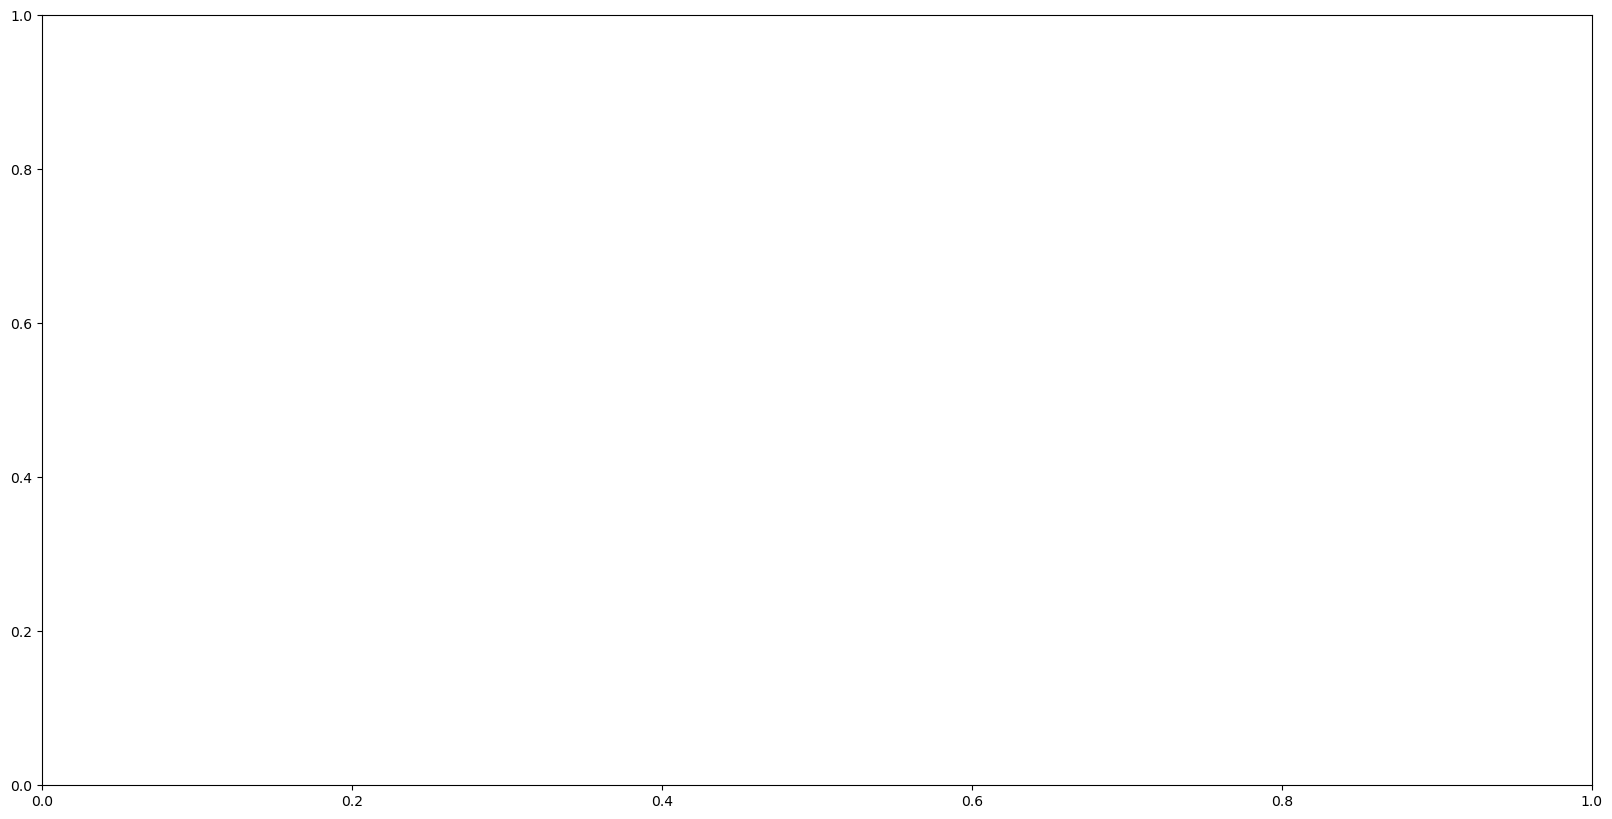

In [245]:
show_dashboard('test')